In [1]:
import os,sys
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
from functools import reduce
from pathlib import Path
import re
import glob

In [14]:
def classify_sgrna(df):
    df['sgRNA_type'] = 'single sgRNA'
    # overwrite where gRNA is missing
    df.loc[df['guide_id'].isna(), 'sgRNA_type'] = 'no sgRNA'
    df.loc[df['guide_id'].str.startswith('NTC', na=False), 'sgRNA_type'] = 'single NTC sgRNA'
    df.loc[df['guide_id'].str.startswith('multi', na=False), 'sgRNA_type'] = 'multi sgRNA'
    # Order the rows
    type_order = ['single sgRNA','single NTC sgRNA','multi sgRNA','no sgRNA']
    df['sgRNA_type'] = pd.Categorical(df['sgRNA_type'],categories=type_order,ordered=True)
    df = df.loc[:, ['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
                    'gRNA', 'guide_id', 'UMI_counts', 'target_gene','sgRNA_type']]
    return df

In [11]:
def plot_lane_sgRNA(df):
    p = (
        ggplot(df, aes(x = 'experiment', fill = 'sgRNA_type'))
        + geom_bar(position="stack")
        + scale_fill_brewer(type='sequential', palette= 5, direction= -1)
        + labs(x = 'Experiment lanes',
              y = 'Cell counts')
        + theme_bw()
        + theme(figure_size=(5, 3),
                legend_title=element_blank(),
                axis_text_x=element_text(rotation=90, 
                                         hjust=1))
        + theme(
            plot_title=element_text(size=16, face="bold", ha='center'),
            axis_title_x=element_text(size=18),
            axis_title_y=element_text(size=18),
            axis_text_x=element_text(size=10),
            axis_text_y=element_text(size=10)
            )
        )
    return p

In [4]:
path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis'
files = [file for file in os.listdir(path) if file.startswith('Mac_')]
files = sorted(files)
files

['Mac_L01_Mac_Ctrl',
 'Mac_L01_Mac_LPS',
 'Mac_L02_Mac_Ctrl',
 'Mac_L02_Mac_LPS',
 'Mac_L03_Mac_Ctrl',
 'Mac_L03_Mac_LPS',
 'Mac_L04_Mac_Ctrl',
 'Mac_L04_Mac_LPS']

In [15]:
df1 = pd.DataFrame()
for i in range(0,len(files)):
    df = pd.DataFrame()
    path = f'/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/{files[i]}/'
    guide_pattern = glob.glob(os.path.join(path, "*_gex_guide.h5ad"))[0]
    # print(guide_pattern)
    adata = sc.read_h5ad(guide_pattern)
    df = adata.obs
    df_guide = classify_sgrna(df)
    df_guide['experiment'] = files[i]
    #     df = pd.concat([df, df_guide])
    df1 = pd.concat([df1, df_guide])

In [16]:
qc_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/qc_stats'
os.makedirs(qc_path, exist_ok= True)
df1.to_csv(os.path.join(qc_path, 'metadata_all_lane_qc.csv'))

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 5 x 3 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/sgRNA_type_distribution.png


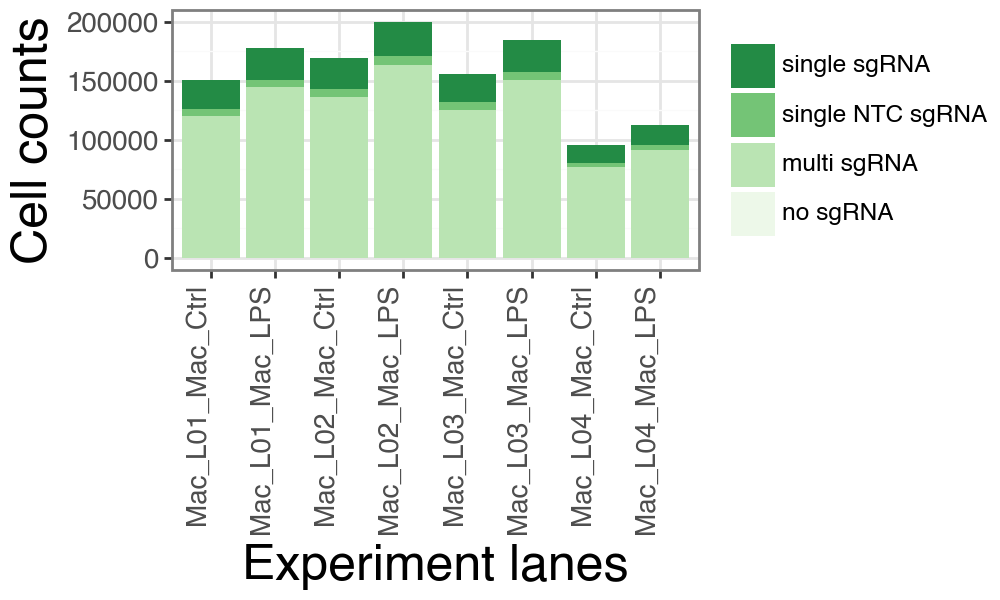

In [17]:
plt_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots'
os.makedirs(plt_path, exist_ok= True)
plt_c = plot_lane_sgRNA(df1)
plt_c.save(os.path.join(plt_path, 'sgRNA_type_distribution.png'), dpi= 150)
plt_c.show()

# 